In [48]:
import numpy as np
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
from chainer import datasets
import chainer.functions as F
import chainer.links as L
import cupy as cp

print('GPU availability:', chainer.cuda.available)
print('cuDNN availability:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availability: True


In [0]:
train, test = chainer.datasets.get_mnist()

In [0]:
trainx = []
traint = []
for x,t in train:
  trainx.append(x)
  traint.append(t)
trainx = cp.array(trainx,dtype = cp.float32)
traint = cp.array(traint,dtype = cp.int32)
del x, t, train

testx = []
testt = []
for x,t in test:
  testx.append(x)
  testt.append(t)
testx = cp.array(testx,dtype = cp.float32)
testt = cp.array(testt,dtype = cp.int32)
del x, t, test

In [0]:
class ConvNet(chainer.Chain):
  def __init__(self, class_num, wh):
    self.class_num = class_num
    self.wh        = wh
    super(ConvNet, self).__init__()
    with self.init_scope():
      self.conv0 = L.Convolution2D(1, 16,3,1,1)
      self.conv1 = L.Convolution2D(16,32,3,1,1)
      self.line0 = L.Linear(None, self.class_num)
      self.bn0   = L.BatchNormalization(16)
      self.bn1   = L.BatchNormalization(32)
  
  def __call__(self, x):
    batch = x.shape[0]
    h = F.leaky_relu(self.bn0(self.conv0(F.reshape(x,(batch,1,self.wh,self.wh)))))
    h = F.leaky_relu(self.bn1(self.conv1(h)))
    h = F.reshape(x,(batch,-1))
    y = self.line0(h)
    return y

In [56]:
class_num = 10
wh = int(trainx.shape[1]**0.5)
batch_size = 1200
epoch = 50
learning_rate =  0.00025
model = ConvNet(class_num, wh)

gpu_device = 0
cuda.get_device(gpu_device).use()
model.to_gpu(gpu_device)

optimizer = chainer.optimizers.Adam(learning_rate)
optimizer.setup(model)

In [57]:
iterations = -((-trainx.shape[0])//batch_size)*epoch
data_array = cp.zeros((5,iterations),dtype=cp.float32)-1
#iteration, train_loss, train_accuracy, test_loss, test_accuracy
del iterations
iteration = -1
for epoch in range(epoch):
    print('epoch:',epoch)
    sum_loss = 0.
    perm = np.random.permutation(trainx.shape[0])
    
    for i in range(0, trainx.shape[0], batch_size):
        train_x_batch = trainx[perm[i: i+batch_size]]
        train_t_batch = traint[perm[i: i+batch_size]]
        model.zerograds()
        y = model(train_x_batch)
        loss = F.softmax_cross_entropy(y,train_t_batch)/batch_size
        loss.backward()
        optimizer.update()
        sum_loss += loss.data
        accuracy = F.accuracy(y,train_t_batch)
        iteration += 1
        data_array[0][iteration] = iteration
        data_array[1][iteration] = loss.data
        data_array[2][iteration] = accuracy.data
        del y, loss, accuracy
    print('sum_loss',sum_loss)
    for j in range(0,testx.shape[0], batch_size):
        test_x_batch = testx[j: j+batch_size]
        test_t_batch = testt[j: j+batch_size]
        model.zerograds()
        y = model(test_x_batch)
        loss = F.softmax_cross_entropy(y,test_t_batch)/batch_size
        accuracy = F.accuracy(y,test_t_batch)
        data_array[3][iteration] = loss.data
        data_array[4][iteration] = accuracy.data
        del y, loss, accuracy

epoch: 0
sum_loss 0.087438114
epoch: 1
sum_loss 0.06853881
epoch: 2
sum_loss 0.055620123
epoch: 3
sum_loss 0.046888616
epoch: 4
sum_loss 0.04083141
epoch: 5
sum_loss 0.036455456
epoch: 6
sum_loss 0.03316402
epoch: 7
sum_loss 0.030611645
epoch: 8
sum_loss 0.028567286
epoch: 9
sum_loss 0.026901344
epoch: 10
sum_loss 0.025511378
epoch: 11
sum_loss 0.024338122
epoch: 12
sum_loss 0.02332956
epoch: 13
sum_loss 0.022456307
epoch: 14
sum_loss 0.021689989
epoch: 15
sum_loss 0.02101337
epoch: 16
sum_loss 0.020411545
epoch: 17
sum_loss 0.019871976
epoch: 18
sum_loss 0.01938313
epoch: 19
sum_loss 0.018941304
epoch: 20
sum_loss 0.018536802
epoch: 21
sum_loss 0.018167213
epoch: 22
sum_loss 0.01782936
epoch: 23
sum_loss 0.017515093
epoch: 24
sum_loss 0.017224766
epoch: 25
sum_loss 0.016954586
epoch: 26
sum_loss 0.016704194
epoch: 27
sum_loss 0.016469765
epoch: 28
sum_loss 0.016249426
epoch: 29
sum_loss 0.016040377
epoch: 30
sum_loss 0.015847307
epoch: 31
sum_loss 0.015663868
epoch: 32
sum_loss 0.0154

In [0]:
data_array = chainer.cuda.to_cpu(data_array)

loss
[0.000e+00 1.000e+00 2.000e+00 ... 2.497e+03 2.498e+03 2.499e+03]


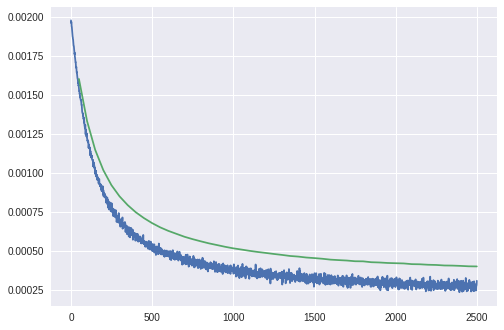

In [63]:
print('loss')
print(data_array[0])
plt.plot(data_array[0],data_array[1])
plt.plot(data_array[0][data_array[3]>=0],data_array[3][data_array[3]>=0])
plt.show()

accuracy


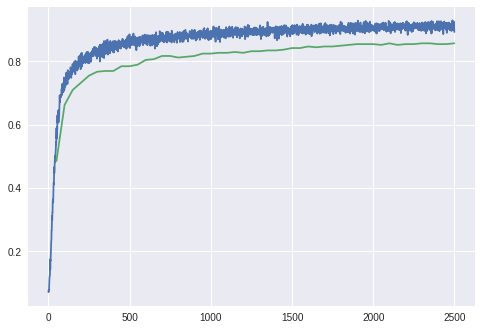

In [64]:
print('accuracy')
plt.plot(data_array[0],data_array[2])
plt.plot(data_array[0][data_array[4]>=0],data_array[4][data_array[4]>=0])
plt.show()